In [1]:
!pip install pyspark

--- Loaded Data Summary (PySpark DataFrames) ---
Demand Data:
root
 |-- node_id: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- demand_kw: double (nullable = true)

+-------+----+---------+
|node_id|hour|demand_kw|
+-------+----+---------+
|     N1|   0|     20.0|
|     N2|   0|     28.0|
|     N3|   0|     22.0|
|     N4|   0|     28.0|
|     N5|   0|     23.0|
+-------+----+---------+
only showing top 5 rows

Total demand entries: 240

Source Data:
root
 |-- source_id: string (nullable = true)
 |-- source_type: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- capacity_kw: double (nullable = true)
 |-- cost_per_kw: double (nullable = true)

+---------+-----------+----+-----------+-----------+
|source_id|source_type|hour|capacity_kw|cost_per_kw|
+---------+-----------+----+-----------+-----------+
|       S1|      Solar|   0|       50.0|        2.0|
|       S1|      Solar|   1|       50.0|        2.0|
|       S1|      Solar|   2|       50.0|       

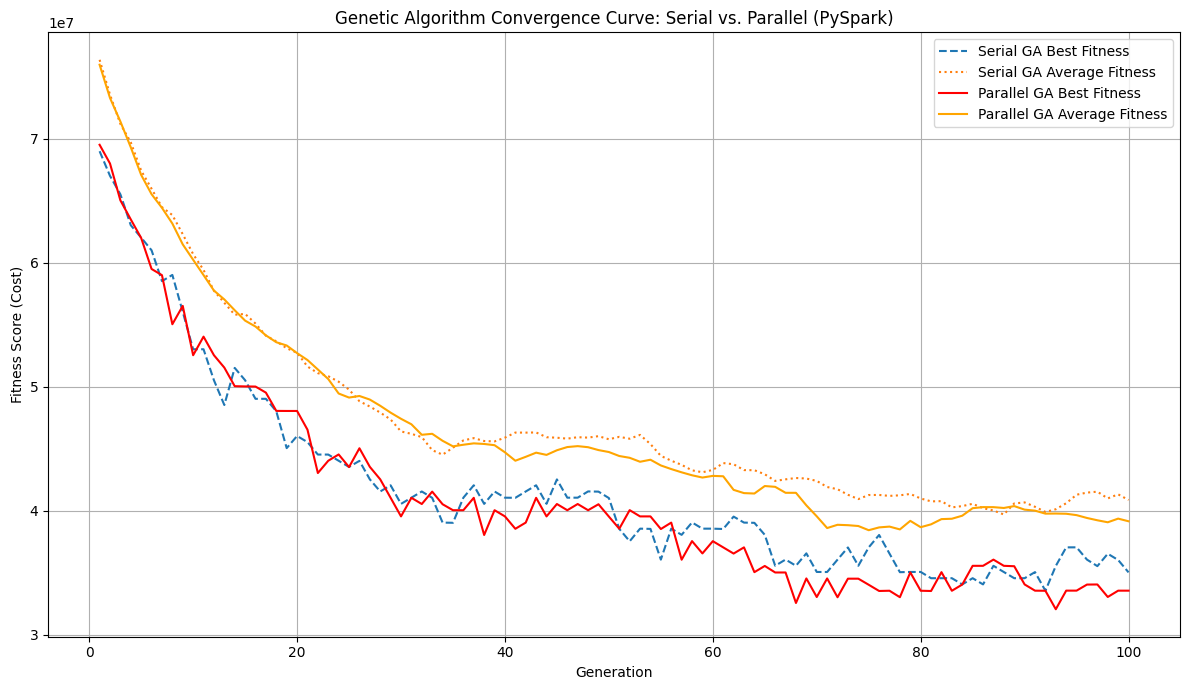

In [3]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported as PySpark often uses it for toPandas()

# Attempt to import SparkSession and other PySpark types
# This block will handle the error if PySpark is not installed
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType
    from pyspark.sql import functions as F
    pyspark_available = True
except ImportError:
    print("PySpark is not installed. Running in serial mode only for GA, and Greedy.")
    pyspark_available = False

# --- Utility Functions (for sample data generation if needed) ---
def generate_sample_data(num_nodes=10, num_sources=3, hours_in_cycle=24):
    """Generates synthetic data for demand, source capacity, and network topology."""
    print(f"Generating sample data with {num_nodes} nodes, {num_sources} sources, {hours_in_cycle} hours.")

    # Demand Data: node_id, hour, demand_kw
    demand_data = []
    for node_idx in range(1, num_nodes + 1):
        for hour_idx in range(hours_in_cycle):
            demand_kw = random.randint(20, 200) # Random demand between 20kW and 200kW
            demand_data.append((f'N{node_idx}', hour_idx, demand_kw)) # Use 'N' prefix for node_id
    demand_df_pd = pd.DataFrame(demand_data, columns=['node_id', 'hour', 'demand_kw'])

    # Source Capacity Data: source_id, source_type, hour, capacity_kw, cost_per_kw
    source_data = []
    source_types = {1: 'Solar', 2: 'Wind', 3: 'Hydro', 4: 'Thermal', 5: 'Battery'}
    for source_idx in range(1, num_sources + 1):
        for hour_idx in range(hours_in_cycle):
            capacity_kw = random.randint(100, 1000) # Random capacity
            cost_per_kw = round(random.uniform(0.05, 0.5), 2) # Random cost
            source_data.append((f'S{source_idx}', source_types.get(source_idx, f'SourceType{source_idx}'), hour_idx, capacity_kw, cost_per_kw)) # Use 'S' prefix for source_id
    source_df_pd = pd.DataFrame(source_data, columns=['source_id', 'source_type', 'hour', 'capacity_kw', 'cost_per_kw'])

    # Network Topology Data: source_id, node_id, distance_km, loss_coefficient
    topology_data = []
    for s_idx in range(1, num_sources + 1):
        for n_idx in range(1, num_nodes + 1):
            distance_km = round(random.uniform(1, 20), 2) # Distance between 1km and 20km
            loss_coefficient = round(random.uniform(0.001, 0.02), 3) # Loss coefficient
            topology_data.append((f'S{s_idx}', f'N{n_idx}', distance_km, loss_coefficient))
    topology_df_pd = pd.DataFrame(topology_data, columns=['source_id', 'node_id', 'distance_km', 'loss_coefficient'])

    return demand_df_pd, source_df_pd, topology_df_pd

# Global Pandas DataFrames to be used
DEMAND_DATA_PD = None
SOURCE_CAPACITY_PD = None
NETWORK_TOPOLOGY_PD = None
ALL_SOURCE_IDS = []

if pyspark_available:
    # Initialize Spark Session (if not already initialized by a test harness)
    spark = SparkSession.builder \
        .appName("SmartGridOptimizationGA") \
        .config("spark.executor.memory", "2g") \
        .config("spark.driver.memory", "2g") \
        .config("spark.driver.maxResultSize", "2g") \
        .getOrCreate()

    # Define schemas to ensure correct data types
    demand_schema = StructType([
        StructField("node_id", StringType(), True),
        StructField("hour", IntegerType(), True),
        StructField("demand_kw", DoubleType(), True)
    ])

    source_schema = StructType([
        StructField("source_id", StringType(), True),
        StructField("source_type", StringType(), True),
        StructField("hour", IntegerType(), True),
        StructField("capacity_kw", DoubleType(), True),
        StructField("cost_per_kw", DoubleType(), True)
    ])

    topology_schema = StructType([
        StructField("source_id", StringType(), True),
        StructField("node_id", StringType(), True),
        StructField("distance_km", DoubleType(), True),
        StructField("loss_coefficient", DoubleType(), True)
    ])

    try:
        # Attempt to load user-provided files first
        spark_demand_df = spark.read.csv("demand_data.csv", header=True, schema=demand_schema)
        spark_source_df = spark.read.csv("source_capacity.csv", header=True, schema=source_schema)
        spark_topology_df = spark.read.csv("network_topology.csv", header=True, schema=topology_schema)

        # Check if loaded dataframes are empty, if so, try 'large' versions or generate
        if spark_demand_df.isEmpty() or spark_source_df.isEmpty() or spark_topology_df.isEmpty():
            raise ValueError("Loaded dataframes are empty, trying large versions or generating sample data.")

        print("--- Loaded Data Summary (PySpark DataFrames) ---")
        print("Demand Data:")
        spark_demand_df.printSchema()
        spark_demand_df.show(5)
        print(f"Total demand entries: {spark_demand_df.count()}")

        print("\nSource Data:")
        spark_source_df.printSchema()
        spark_source_df.show(5)
        print(f"Total source entries: {spark_source_df.count()}")

        print("\nTopology Data:")
        spark_topology_df.printSchema()
        spark_topology_df.show(5)
        print(f"Total topology entries: {spark_topology_df.count()}")
        print("-" * 30)

        # Convert Spark DataFrames to Pandas DataFrames for global use
        DEMAND_DATA_PD = spark_demand_df.toPandas()
        SOURCE_CAPACITY_PD = spark_source_df.groupBy("source_id", "hour").agg(
            F.mean("capacity_kw").alias("capacity_kw"),
            F.mean("cost_per_kw").alias("cost_per_kw")
        ).toPandas().set_index(['source_id', 'hour'])
        NETWORK_TOPOLOGY_PD = spark_topology_df.toPandas().set_index(['source_id', 'node_id'])
        ALL_SOURCE_IDS = [row.source_id for row in spark_source_df.select("source_id").distinct().collect()]


    except Exception as e:
        print(f"Error loading initial CSVs or they were empty: {e}")
        print("Attempting to load 'large' datasets...")
        try:
            spark_demand_df = spark.read.csv("large_demand_data.csv", header=True, schema=demand_schema)
            spark_source_df = spark.read.csv("large_source_capacity.csv", header=True, schema=source_schema)
            spark_topology_df = spark.read.csv("large_network_topology.csv", header=True, schema=topology_schema)

            if spark_demand_df.isEmpty() or spark_source_df.isEmpty() or spark_topology_df.isEmpty():
                raise ValueError("Loaded 'large' dataframes are also empty, generating sample data.")

            print("--- Loaded Large Data Summary (PySpark DataFrames) ---")
            print("Demand Data:")
            spark_demand_df.printSchema()
            spark_demand_df.show(5)
            print(f"Total demand entries: {spark_demand_df.count()}")

            print("\nSource Data:")
            spark_source_df.printSchema()
            spark_source_df.show(5)
            print(f"Total source entries: {spark_source_df.count()}")

            print("\nTopology Data:")
            spark_topology_df.printSchema()
            spark_topology_df.show(5)
            print(f"Total topology entries: {spark_topology_df.count()}")
            print("-" * 30)

            # Convert Spark DataFrames to Pandas DataFrames for global use
            DEMAND_DATA_PD = spark_demand_df.toPandas()
            SOURCE_CAPACITY_PD = spark_source_df.groupBy("source_id", "hour").agg(
                F.mean("capacity_kw").alias("capacity_kw"),
                F.mean("cost_per_kw").alias("cost_per_kw")
            ).toPandas().set_index(['source_id', 'hour'])
            NETWORK_TOPOLOGY_PD = spark_topology_df.toPandas().set_index(['source_id', 'node_id'])
            ALL_SOURCE_IDS = [row.source_id for row in spark_source_df.select("source_id").distinct().collect()]

        except Exception as e_large:
            print(f"Error loading 'large' CSVs or they were empty: {e_large}")
            # Fallback to generating sample data if no CSVs are found or cause issues
            print("Falling back to generating sample data as CSV loading failed for both attempts.")
            DEMAND_DATA_PD, SOURCE_CAPACITY_PD, NETWORK_TOPOLOGY_PD = generate_sample_data(num_nodes=10, num_sources=3, hours_in_cycle=24)
            # Infer ALL_SOURCE_IDS from generated data
            ALL_SOURCE_IDS = SOURCE_CAPACITY_PD.index.get_level_values('source_id').unique().tolist()
else: # PySpark not available, generate data directly into Pandas
    print("PySpark is not available. Generating sample data for serial execution.")
    DEMAND_DATA_PD, SOURCE_CAPACITY_PD, NETWORK_TOPOLOGY_PD = generate_sample_data(num_nodes=10, num_sources=3, hours_in_cycle=24)
    # Infer ALL_SOURCE_IDS from generated data
    ALL_SOURCE_IDS = SOURCE_CAPACITY_PD.index.get_level_values('source_id').unique().tolist()


# --- Genetic Algorithm Parameters ---
NUM_GENERATIONS = 100
POPULATION_SIZE = 100
# Ensure CHROMOSOME_LENGTH is based on the number of rows in the demand data
CHROMOSOME_LENGTH = len(DEMAND_DATA_PD)
MUTATION_RATE = 0.05

print(f"Genetic Algorithm Parameters:")
print(f"  Number of Generations: {NUM_GENERATIONS}")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Chromosome Length (demand points): {CHROMOSOME_LENGTH}")
print(f"  Mutation Rate: {MUTATION_RATE}")
print("-" * 30)

# --- Chromosome Utilities ---
def initialize_population(pop_size, gene_pool, chromosome_length):
    """
    Initializes a population of chromosomes.
    Each chromosome is a list where each element (gene) is a source_id
    assigned to a corresponding demand point.
    """
    return [np.random.choice(gene_pool, size=chromosome_length).tolist() for _ in range(pop_size)]

def crossover(parent1, parent2, chromosome_length):
    """
    Performs single-point crossover between two parents to produce one child.
    """
    if chromosome_length < 2:
        return random.choice([parent1, parent2])

    point = random.randint(1, chromosome_length - 1)
    child = parent1[:point] + parent2[point:]
    return child

def mutate(chromosome, gene_pool, mutation_rate):
    """
    Applies mutation to a chromosome.
    For each gene, there's a chance (mutation_rate) for it to be replaced
    with a random gene from the gene_pool.
    """
    mutated_chromosome = list(chromosome) # Create a mutable copy
    for i in range(len(mutated_chromosome)):
        if random.random() < mutation_rate:
            mutated_chromosome[i] = random.choice(gene_pool)
    return mutated_chromosome

# --- Single Chromosome Fitness Calculation (used by both serial and parallel GA) ---
def calculate_single_chromosome_fitness(chromosome_as_list, demand_data, source_grouped, topology_lookup):
    """
    Calculates fitness for a single chromosome.
    This function expects Pandas DataFrames for demand_data, source_grouped, and topology_lookup.
    """
    total_cost = 0
    penalty = 0

    # Iterate through each demand point in the chromosome
    for idx, gene_source_id in enumerate(chromosome_as_list):
        try:
            # Get demand details
            demand_point = demand_data.iloc[idx]
            node_id = demand_point['node_id']
            hour = demand_point['hour']
            demand_kw = demand_point['demand_kw']

            # Lookup source capacity and cost
            capacity_info = source_grouped.loc[(gene_source_id, hour)]
            available_capacity = capacity_info['capacity_kw']
            cost_per_kw = capacity_info['cost_per_kw']

            # Lookup transmission distance and loss coefficient
            connection_info = topology_lookup.loc[(gene_source_id, node_id)]
            distance = connection_info['distance_km']
            loss_coefficient = connection_info['loss_coefficient']

            # Calculate energy needed at source, considering transmission loss
            energy_at_source_needed = demand_kw * (1 + loss_coefficient * distance)

            # Constraint: Max Capacity - Penalize if source cannot meet adjusted demand
            if available_capacity < energy_at_source_needed:
                penalty += 1000 * (energy_at_source_needed - available_capacity) # High penalty for unmet demand

            # Calculate cost for this specific allocation
            total_cost += energy_at_source_needed * cost_per_kw

        except KeyError:
            # This occurs if a (source_id, hour) or (source_id, node_id) mapping is missing
            # which indicates an invalid or unfeasible assignment for that gene.
            penalty += 500000 # Very high penalty
        except Exception as e:
            # Catch any other unexpected errors during calculation
            # print(f"An unexpected error occurred during fitness evaluation for chromosome index {idx}: {e}")
            penalty += 1000000 # Extremely high penalty for unknown errors

    return total_cost + penalty

# --- Tournament Selection ---
def tournament_selection(population, fitness_scores, k=3):
    """
    Selects individuals for the next generation using tournament selection.
    k specifies the number of individuals participating in each tournament.
    """
    selected = []
    population_with_fitness = list(zip(population, fitness_scores))
    for _ in range(len(population)):
        contenders = random.sample(population_with_fitness, k)
        winner = min(contenders, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# --- Parallel Genetic Algorithm Implementation (PySpark) ---
def genetic_algorithm_spark(demand_df_pd, source_df_pd, topology_df_pd, num_generations, pop_size, mutation_rate):
    if not pyspark_available:
        print("PySpark is not available, skipping parallel GA.")
        return None, [], [], 0

    print("\n--- Running Parallel Genetic Algorithm (PySpark) ---")
    start_time = time.time()

    best_fitness_history = []
    avg_fitness_history = []

    # Broadcast static data for efficient access on workers
    b_demand_pd = spark.sparkContext.broadcast(demand_df_pd)
    b_source_grouped_pd = spark.sparkContext.broadcast(source_df_pd)
    b_topology_lookup_pd = spark.sparkContext.broadcast(topology_df_pd)

    # Function to be mapped over RDD for parallel fitness evaluation
    def map_fitness(chromosome):
        return calculate_single_chromosome_fitness(
            chromosome,
            b_demand_pd.value,
            b_source_grouped_pd.value,
            b_topology_lookup_pd.value
        )

    population = initialize_population(pop_size, ALL_SOURCE_IDS, CHROMOSOME_LENGTH)

    for generation in range(num_generations):
        # Evaluate fitness in parallel using Spark
        fitness_scores = spark.sparkContext.parallelize(population).map(map_fitness).collect()

        best_fitness_current_gen = min(fitness_scores)
        avg_fitness_current_gen = sum(fitness_scores) / len(fitness_scores)

        best_fitness_history.append(best_fitness_current_gen)
        avg_fitness_history.append(avg_fitness_current_gen)

        if generation % 10 == 0:
            print(f"Generation {generation}/{num_generations} - Best Fitness: {best_fitness_current_gen:.2f}, Avg Fitness: {avg_fitness_current_gen:.2f}")

        # Selection
        selected_population = tournament_selection(population, fitness_scores)

        # Create next generation
        next_population = []
        for i in range(0, pop_size, 2):
            parent1 = random.choice(selected_population)
            parent2 = random.choice(selected_population)
            child1 = crossover(parent1, parent2, CHROMOSOME_LENGTH)
            child2 = crossover(parent2, parent1, CHROMOSOME_LENGTH) # Produce two children for better diversity
            next_population.append(mutate(child1, ALL_SOURCE_IDS, mutation_rate))
            next_population.append(mutate(child2, ALL_SOURCE_IDS, mutation_rate))

        # Ensure population size remains constant (handle odd sizes or rounding from crossover)
        population = next_population[:pop_size]

    # After evolution, find the best solution in the final population
    final_fitness_scores = spark.sparkContext.parallelize(population).map(map_fitness).collect()
    best_solution_index = final_fitness_scores.index(min(final_fitness_scores))
    best_solution = population[best_solution_index]
    best_fitness = final_fitness_scores[best_solution_index]

    end_time = time.time()
    runtime = end_time - start_time
    print(f"Parallel Genetic Algorithm Runtime: {runtime:.2f} seconds")
    print(f"Parallel GA Best Fitness: {best_fitness:.2f}")
    print("-" * 30)

    return best_solution, best_fitness_history, avg_fitness_history, runtime

# --- Serial Genetic Algorithm Implementation ---
def genetic_algorithm_serial(demand_df_pd, source_df_pd, topology_df_pd, num_generations, pop_size, mutation_rate):
    print("\n--- Running Serial Genetic Algorithm ---")
    start_time = time.time()

    best_fitness_history = []
    avg_fitness_history = []

    population = initialize_population(pop_size, ALL_SOURCE_IDS, CHROMOSOME_LENGTH)

    for generation in range(num_generations):
        fitness_scores = []
        for chromosome in population:
            fitness = calculate_single_chromosome_fitness(
                chromosome,
                demand_df_pd,
                source_df_pd,
                topology_df_pd
            )
            fitness_scores.append(fitness)

        best_fitness_current_gen = min(fitness_scores)
        avg_fitness_current_gen = sum(fitness_scores) / len(fitness_scores)

        best_fitness_history.append(best_fitness_current_gen)
        avg_fitness_history.append(avg_fitness_current_gen)

        if generation % 10 == 0:
            print(f"Generation {generation}/{num_generations} - Best Fitness: {best_fitness_current_gen:.2f}, Avg Fitness: {avg_fitness_current_gen:.2f}")

        # Selection
        selected_population = tournament_selection(population, fitness_scores)

        # Create next generation
        next_population = []
        for i in range(0, pop_size, 2):
            parent1 = random.choice(selected_population)
            parent2 = random.choice(selected_population)
            child1 = crossover(parent1, parent2, CHROMOSOME_LENGTH)
            child2 = crossover(parent2, parent1, CHROMOSOME_LENGTH)
            next_population.append(mutate(child1, ALL_SOURCE_IDS, mutation_rate))
            next_population.append(mutate(child2, ALL_SOURCE_IDS, mutation_rate))

        population = next_population[:pop_size]

    final_fitness_scores = []
    for chromosome in population:
        fitness = calculate_single_chromosome_fitness(
            chromosome,
            demand_df_pd,
            source_df_pd,
            topology_df_pd
        )
        final_fitness_scores.append(fitness)

    best_solution_index = final_fitness_scores.index(min(final_fitness_scores))
    best_solution = population[best_solution_index]
    best_fitness = final_fitness_scores[best_solution_index]

    end_time = time.time()
    runtime = end_time - start_time
    print(f"Serial Genetic Algorithm Runtime: {runtime:.2f} seconds")
    print(f"Serial GA Best Fitness: {best_fitness:.2f}")
    print("-" * 30)

    return best_solution, best_fitness_history, avg_fitness_history, runtime

# --- Baseline Method (Greedy Approach) ---
def greedy_algorithm_runner(demand_df_pd, source_df_pd, topology_df_pd):
    """
    A simple greedy algorithm for energy distribution.
    For each demand point, it tries to assign the cheapest available source
    that can meet the demand (considering losses), prioritizing cost.
    This version operates directly on Pandas DataFrames.
    """
    print("\n--- Running Greedy Algorithm (Baseline) ---")
    start_time = time.time()

    total_cost = 0
    total_penalty = 0
    assigned_sources = [None] * len(demand_df_pd) # To store the greedy solution chromosome

    for idx, demand_point in demand_df_pd.iterrows():
        node_id = demand_point['node_id']
        hour = demand_point['hour']
        demand_kw = demand_point['demand_kw']

        best_assignment_cost = float('inf')
        best_source = None

        # Iterate through all possible sources for this demand point
        for source_id in ALL_SOURCE_IDS:
            try:
                # Get source info
                capacity_info = source_df_pd.loc[(source_id, hour)]
                available_capacity = capacity_info['capacity_kw']
                cost_per_kw = capacity_info['cost_per_kw']

                # Get topology info
                connection_info = topology_df_pd.loc[(source_id, node_id)]
                distance = connection_info['distance_km']
                loss_coefficient = connection_info['loss_coefficient']

                energy_at_source_needed = demand_kw * (1 + loss_coefficient * distance)

                if available_capacity >= energy_at_source_needed:
                    current_assignment_cost = energy_at_source_needed * cost_per_kw
                    if current_assignment_cost < best_assignment_cost:
                        best_assignment_cost = current_assignment_cost
                        best_source = source_id
            except KeyError:
                continue # This source-node or source-hour combination does not exist, skip
            except Exception as e:
                # print(f"Error in greedy lookup: {e}") # Suppress verbose error for cleaner output
                continue

        if best_source is not None:
            total_cost += best_assignment_cost
            assigned_sources[idx] = best_source
        else:
            # If no source can meet the demand for this point, add a penalty
            total_penalty += 100000 # Large penalty for unmet demand
            assigned_sources[idx] = random.choice(ALL_SOURCE_IDS) # Assign a random source to complete chromosome

    final_greedy_cost = total_cost + total_penalty
    end_time = time.time()
    greedy_runtime = end_time - start_time
    print(f"Greedy Algorithm Runtime: {greedy_runtime:.2f} seconds")
    print(f"Greedy Algorithm Total Cost: {final_greedy_cost:.2f}")
    print("-" * 30)
    return final_greedy_cost, assigned_sources, greedy_runtime


# --- Main Runner Function ---
def run_all_algorithms():
    serial_ga_runtime = 0
    serial_best_fitness_history = []
    serial_avg_fitness_history = []
    spark_ga_runtime = 0
    spark_best_fitness_history = []
    spark_avg_fitness_history = []
    greedy_cost = 0
    greedy_runtime = 0

    # 1. Run Serial Genetic Algorithm
    _, serial_best_fitness_history, serial_avg_fitness_history, serial_ga_runtime = genetic_algorithm_serial(
        DEMAND_DATA_PD, SOURCE_CAPACITY_PD, NETWORK_TOPOLOGY_PD,
        NUM_GENERATIONS, POPULATION_SIZE, MUTATION_RATE
    )

    # 2. Run Parallel Genetic Algorithm (PySpark) if available
    if pyspark_available:
        _, spark_best_fitness_history, spark_avg_fitness_history, spark_ga_runtime = genetic_algorithm_spark(
            DEMAND_DATA_PD, SOURCE_CAPACITY_PD, NETWORK_TOPOLOGY_PD,
            NUM_GENERATIONS, POPULATION_SIZE, MUTATION_RATE
        )

    # 3. Run Greedy Algorithm (Baseline)
    greedy_cost, _, greedy_runtime = greedy_algorithm_runner(
        DEMAND_DATA_PD, SOURCE_CAPACITY_PD, NETWORK_TOPOLOGY_PD
    )


    # --- Final Performance Analysis and Result Interpretation ---
    print("\n--- Final Performance Comparison ---")
    if serial_best_fitness_history:
        print(f"Serial GA Best Cost: {serial_best_fitness_history[-1]:.2f}")
    if spark_best_fitness_history:
        print(f"Parallel GA Best Cost: {spark_best_fitness_history[-1]:.2f}")
    print(f"Greedy Algorithm Total Cost: {greedy_cost:.2f}")

    print(f"\nRuntime Comparison:")
    if serial_ga_runtime:
        print(f"Serial GA Runtime: {serial_ga_runtime:.2f} seconds")
    if spark_ga_runtime:
        print(f"Parallel GA Runtime (PySpark): {spark_ga_runtime:.2f} seconds")
    print(f"Greedy Algorithm Runtime: {greedy_runtime:.2f} seconds")

    # Determine which GA is better (if both ran)
    if serial_best_fitness_history and spark_best_fitness_history:
        if serial_best_fitness_history[-1] < spark_best_fitness_history[-1]:
            print("Serial GA found a slightly better (or equal) solution than Parallel GA for the same generations.")
        elif spark_best_fitness_history[-1] < serial_best_fitness_history[-1]:
            print("Parallel GA found a slightly better (or equal) solution than Serial GA for the same generations.")
        else:
            print("Both Serial and Parallel GAs found solutions of similar quality.")
    elif serial_best_fitness_history:
        print("Only Serial GA results available.")
    elif spark_best_fitness_history:
        print("Only Parallel GA results available.")


    # Compare GA best with Greedy
    best_overall_ga_cost = float('inf')
    if serial_best_fitness_history:
        best_overall_ga_cost = min(best_overall_ga_cost, serial_best_fitness_history[-1])
    if spark_best_fitness_history:
        best_overall_ga_cost = min(best_overall_ga_cost, spark_best_fitness_history[-1])

    if best_overall_ga_cost != float('inf'): # If at least one GA ran
        if best_overall_ga_cost < greedy_cost:
            print(f"Genetic Algorithm (best of serial/parallel) found a better solution ({best_overall_ga_cost:.2f}) than the Greedy Algorithm ({greedy_cost:.2f}).")
        else:
            print(f"Greedy Algorithm found a comparable or better solution ({greedy_cost:.2f}) than the Genetic Algorithm ({best_overall_ga_cost:.2f}). (Consider more generations/tuning for GA).")
    print("-" * 30)

    # Plot convergence curves for both Serial and Parallel GA
    plt.figure(figsize=(12, 7))
    if serial_best_fitness_history:
        plt.plot(range(1, NUM_GENERATIONS + 1), serial_best_fitness_history, label='Serial GA Best Fitness', linestyle='--')
        plt.plot(range(1, NUM_GENERATIONS + 1), serial_avg_fitness_history, label='Serial GA Average Fitness', linestyle=':')
    if spark_best_fitness_history:
        plt.plot(range(1, NUM_GENERATIONS + 1), spark_best_fitness_history, label='Parallel GA Best Fitness', color='red')
        plt.plot(range(1, NUM_GENERATIONS + 1), spark_avg_fitness_history, label='Parallel GA Average Fitness', color='orange')

    if serial_best_fitness_history or spark_best_fitness_history:
        plt.xlabel('Generation')
        plt.ylabel('Fitness Score (Cost)')
        plt.title('Genetic Algorithm Convergence Curve: Serial vs. Parallel (PySpark)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig('ga_convergence_serial_vs_parallel.png')
    else:
        print("No GA convergence plot generated as neither serial nor parallel GA could be executed.")


# --- Main Execution Block ---
if __name__ == "__main__":
    run_all_algorithms()
    if pyspark_available:
        spark.stop() # Stop SparkSession at the end